In [1]:
import sys
import os
import numpy as np
sys.path.insert(0, '..')

In [2]:
from gait_analysis.Datasets import TumGAID_Dataset
from gait_analysis import settings as S

## TUMGAID example
tumgaid_args = {
    'load_pose': True,
    'load_pose_options': {
        'D': 2,
        'body_keypoints_include_list': ['LAnkle',
                                        'RAnkle',
                                        'LKnee',
                                        'RKnee',
                                        'RHip',
                                        'LHip']
    },
    'load_flow': False,
    'load_flow_options': {
        'method': 'dense',
        'load_patches': True,
        'load_patch_options': {
            'patch_size': 5
        }
    },
    'load_scene': False,
    'load_scene_options': {
        'grayscale': False,
        'load_tracked': False
    },
    'include_scenes': ['b01', 'b02', 'n01', 'n02', 's01', 's02'],

}
tg_dset = TumGAID_Dataset(S.tumgaid_root,
                          S.tumgaid_preprocessing_root,
                          S.tumgaid_annotations_root,
                          tumgaid_args)

In [3]:
tg_dset.p_nums
data, annoations = tg_dset[0]
print(data.keys())
print('pose_keypoints : {}'.format(len(data['pose_keypoints'])))

['pose_keypoints']
pose_keypoints : 39


/home/sandro/anaconda2/envs/gait_27/lib/python2.7/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [4]:
data, annotations = tg_dset[0]
p = data['pose_keypoints']
p[0]

[array([287.624, 330.745]),
 array([244.542, 350.247]),
 array([245.852, 286.37 ]),
 array([266.713, 282.438]),
 array([184.517, 393.346]),
 array([294.137, 392.073])]

In [5]:
class Pose():
    pose_keypoints = None
    def __init__(self, pose_keypoints):
        assert type(pose_keypoints) == list
        self.pose_keypoints = pose_keypoints
        
    def __sub__(pose1, pose2):
        diff_pose = []
        for arr1, arr2 in zip(pose1.pose_keypoints, pose2.pose_keypoints):
            diff_pose.append(arr1 - arr2)
        return Pose(diff_pose)
    
    def __str__(self):
        return self.pose_keypoints.__str__()
    
    def to_list(self):
        return self.pose_keypoints
    
def extract_pose(tg_dset, i):    
    data, annotations = tg_dset[i]
    p = data['pose_keypoints'][0]
    return p
    
pose1 = Pose(extract_pose(tg_dset, 0))
pose2 = Pose(extract_pose(tg_dset, 2))

print(pose1)
print(pose2)
print(pose1 - pose2)

[array([287.624, 330.745]), array([244.542, 350.247]), array([245.852, 286.37 ]), array([266.713, 282.438]), array([184.517, 393.346]), array([294.137, 392.073])]
[array([206.702, 320.324]), array([151.94 , 348.987]), array([144.073, 282.42 ]), array([170.193, 275.912]), array([144.086, 411.635]), array([192.355, 382.946])]
[array([80.922, 10.421]), array([92.602,  1.26 ]), array([101.779,   3.95 ]), array([96.52 ,  6.526]), array([ 40.431, -18.289]), array([101.782,   9.127])]


## Settings

In [6]:
diff_poses = True

# Split dataset into Train and Validation

In [7]:
import sklearn
from sklearn.model_selection import train_test_split

split_index = 10
p_nums_train = tg_dset.p_nums[:split_index]
p_nums_test = tg_dset.p_nums[split_index:]
def create_idx_list(p_nums_list):
    idx_list = []
    for i, dset_item in enumerate(tg_dset.dataset_items):
        p_num, _ = dset_item
        if p_num in p_nums_list:
            idx_list.append(i)
    return idx_list
idx_train = create_idx_list(p_nums_train)
idx_test = create_idx_list(p_nums_test)

# Training Loop

In [8]:
def annotations_to_targets(annotations):
    '''
    IN_THE_AIR == TRUE
    '''
    a = annotations.left_foot.values == 'IN_THE_AIR'    
    return a * 1

def flatten_features(single_frame_feature):
    return np.ravel(single_frame_feature)

from itertools import *
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return list(zip(a, b))

def maybe_subtract_poses(pose_keypoints, diff_poses):
    if diff_poses:
        augmented_list = [pose_keypoints[0]] + pose_keypoints
        poses = []
        for p1, p2 in pairwise(augmented_list):
            diff_pose = Pose(p1) - Pose(p2)
            poses.append(diff_pose.to_list())
        return poses
    return pose_keypoints

temporal_extent = 2 #will concatenate +- N frame features together into a single feature vector

In [9]:
data, annotations = tg_dset[0]
p = data['pose_keypoints']
len(flatten_features(p[0]))


pose_keypoints = p
diff_poses = True
p_new = maybe_subtract_poses(pose_keypoints, diff_poses)

In [10]:
def yield_kXY(temporal_extent, flat_features, targets):
    '''
    yields an X and a Y given a list of flat_features and a list of targets.
    The temporal_extent will concatenate neighboring frames into a single features vector.
    The target will be the center frame of the concatenate extent
    
    yields index k of the sequence of flat_features
    concatenated features X
    target Y
    '''
    for k in range(temporal_extent, len(flat_features) - temporal_extent):
        x_start, x_end = np.array([-temporal_extent, temporal_extent]) + k
        X = np.hstack(flat_features[x_start:x_end + 1])
        X = np.reshape(X, (1, -1))
        Y = targets[k]
        yield k, X, Y

# Initialize Model

In [23]:
#from gait_analysis.Models.OtherModels import SVMModel
from gait_analysis.Models.BaseModels import AbstractGaitModel
from gait_analysis.Models.OtherModels import SVMModel
from sklearn import svm

svm_obj = svm.SVC(kernel='linear')
model = SVMModel(svm_obj)

In [24]:
for idx in idx_train:
    features, annotations = tg_dset[idx]
    targets = annotations_to_targets(annotations)
    list_of_single_frame_features = features['pose_keypoints']
    list_of_single_frame_features = maybe_subtract_poses(list_of_single_frame_features, diff_poses)
    flat_features = list(map(flatten_features, list_of_single_frame_features))
    for _, X, Y in yield_kXY(temporal_extent, flat_features, targets):
        model.train(X, Y)
model.finish_training() # actually fit svm

In [25]:
import pandas as pd
result_dict = {}
for idx in idx_test:
    features, annotations = tg_dset[idx]
    targets = annotations_to_targets(annotations)
    list_of_single_frame_features = features['pose_keypoints']
    list_of_single_frame_features = maybe_subtract_poses(list_of_single_frame_features, diff_poses)
    flat_features = list(map(flatten_features, list_of_single_frame_features))
    
    sequence_output = {
        'frame_id' : [],
        'target' : [],
        'prediction' : []
    }
    for k, X, Y in yield_kXY(temporal_extent, flat_features, targets):
        prediction = model.svm_obj.predict(X)                
        sequence_output['frame_id'].append(k)
        sequence_output['target'].append(Y)
        sequence_output['prediction'].append(prediction)
        
    result_dict[idx] = sequence_output

In [16]:
df = pd.DataFrame(result_dict)

[array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0])]

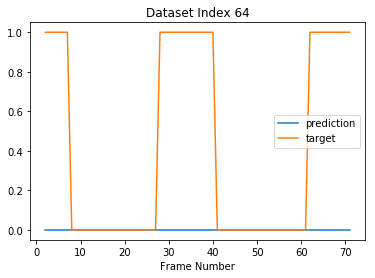

In [22]:
from matplotlib import pyplot as plt
df = pd.DataFrame(result_dict)
def plot_single_sequence(sequence_id, data_frame):
    a = data_frame[sequence_id]
    fig, ax = plt.subplots()
    x = a['frame_id']
    ax.plot(x, a['prediction'], label='prediction')
    ax.plot(x, a['target'], label='target')
    plt.legend()
    plt.xlabel('Frame Number')
    plt.title('Dataset Index {}'.format(sequence_id))
    return fig, ax

%matplotlib inline
fig, ax = plot_single_sequence(64, df)